# Target move experiment

In [1]:
from Helpers import *

In [2]:
def Feedback_Linearization(Duration,w1,w2,w3,w4,r1,r2,targets = [0,50],starting_point = [0,35],plot = True,Noise_Variance = 1e-6,newtonfunc = f,newtondfunc = df,Num_iter = 600,new_target = [10,50], JumpTime = .3,ShowL = False):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noise in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)
    """

    dt = Duration/Num_iter 

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1])
    obj3,obj4 = newton(newtonfunc,newtondfunc,1e-8,1000,new_target[0],new_target[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = Q+A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
    
    #Initialize matrices 

    sigma = np.identity(Num_Var)*10**-6 
    H,L = np.identity(8),array_L
    if ShowL:
        for u in range(2):
            for k in range(Num_Var):
                plt.plot(np.linspace(0,Duration,Num_iter-1),L[:,u,k])
            plt.show()
    #Initialize the arrays to stock the simulations 
    array_xhat = np.zeros((Num_iter,Num_Var))
    array_x_nonlin = np.zeros((Num_iter,Num_Var-2)) 
    y = np.zeros((Num_iter,Num_Var))

    #Initialize the state vectors of the linear system
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0)
    x_true = np.copy(x0)

    #Initialize the state vectors of the nonlinear system
    x_nonlin = np.zeros(Num_Var-2)
    x_nonlin[0],x_nonlin[1] = x0[0],x0[3]

    new_x_nonlin = np.copy(x_nonlin)

    #Perform the task
    Reach = False
    for k in range(Num_iter-1):

        #Compute the matrices of the system in function of the current state 

        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
            
        C = np.array([-x_nonlin[3]*(2*x_nonlin[2]+x_nonlin[3])*a2*np.sin(x_nonlin[1]),x_nonlin[2]*x_nonlin[2]*a2*np.sin(x_nonlin[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x_nonlin[1])*np.cos(x_nonlin[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(x_nonlin[1])-a3)/Denominator],[(-a2*np.cos(x_nonlin[1])-a3)/Denominator,(2*a2*np.cos(x_nonlin[1])+a1)/Denominator]])
        
        Denominator = a3*(a1-a3)-a2*a2*np.cos(xhat[3])*np.cos(xhat[3])
        M = np.array([[a1+2*a2*cos(xhat[3]),a3+a2*cos(xhat[3])],[a3+a2*cos(xhat[3]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*xhat[3])*xhat[4]/(Denominator*Denominator),
                             (a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)],
                            [(a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator),
                            (-2*a2*sin(xhat[3])*xhat[4]*Denominator+(2*a2*cos(xhat[3])+a1)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*xhat[5]*(2*xhat[1]+xhat[4])*sin(xhat[3])-a2*xhat[4]*(2*xhat[2]+xhat[5])*sin(xhat[3])
                         -a2*xhat[4]*xhat[4]*(2*xhat[1]+xhat[4])*cos(xhat[3]),2*xhat[1]*xhat[2]*a2*sin(xhat[3])+xhat[1]*xhat[1]*a2*cos(xhat[3])*xhat[4]])
        
        COLORS = "red"
        LABEL = "Feedback Linearization"


        # Compute the command 

        v = -L[k].reshape(np.flip(B.shape))@xhat
        u = 1/Kfactor*M@(v)-1/Kfactor*M@Minvdot@M@(np.array([xhat[2],xhat[5]]))+M@(np.array([xhat[2],xhat[5]]))+C+Bdyn@np.array([xhat[1],xhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([xhat[2],xhat[5]])
        # True state of the system
        new_x_nonlin[0:2] += dt*x_nonlin[2:4]
        new_x_nonlin[2:4] += dt*(Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))  
        new_x_nonlin[4:6] += dt*Kfactor*(u-x_nonlin[4:6])
            
        array_xhat[k+1] = xhat.flatten()
        array_x_nonlin[k+1] = new_x_nonlin.flatten()

        y[k] = (H@x_true+measure_noise).flatten()
        #Change of variable 
        

        #Perform Iteration 
        
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        #print(y[k]-H@x_internalmodel)
        xhat = A@xhat+B@v + K@(y[k]-H@xhat)

        x_true = np.array([new_x_nonlin[0],new_x_nonlin[2],x_true[2]+dt*v[0],new_x_nonlin[1],new_x_nonlin[3],x_true[5]+dt*v[1],x_true[6],x_true[7]])
        if dt*k > JumpTime: 
            x_true[6:8] = [obj3,obj4]
            xhat[6:8] = [obj3,obj4]

        x_nonlin = np.copy(new_x_nonlin)
        X = np.cos(x_nonlin[0]+x_nonlin[1])*33+np.cos(x_nonlin[0])*30
        Y = np.sin(x_nonlin[0]+x_nonlin[1])*33+np.sin(x_nonlin[0])*30
        if (np.sqrt((X-targets[0])**2+(Y-targets[1])**2) < 1) and (Reach == False):
            Reach = True
            print("The subject has reached the first target in ",k*dt," seconds\n")
        
        if (np.sqrt((X-new_target[0])**2+(Y-new_target[1])**2) < 1) and (Reach == False):
            Reach = True
            print("The subject has reached the target after the jump in ",k*dt," seconds\n")
        #print(array_x_true[k-1,2],((array_x_true[k]-array_x_true[k-1])/dt)[1])   

    #Change of coordinates from angular to cartesian 
    x_nonlin = array_x_nonlin.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[1])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[1])*33+np.sin(x_nonlin[0])*30

    #Plotting
    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = COLORS,label = LABEL,linewidth = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0],new_target[0]],[starting_point[1],targets[1],new_target[1]],color = "black")
    #print("Optimum values " + str(J1)[:8]+" and "+str(J2)[:8])

    
    return X,Y

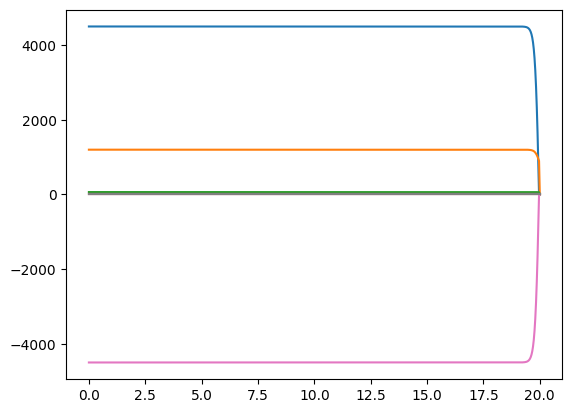

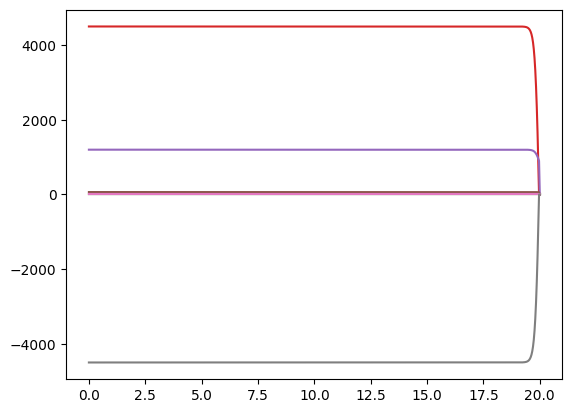

The subject has reached the first target in  0.5  seconds



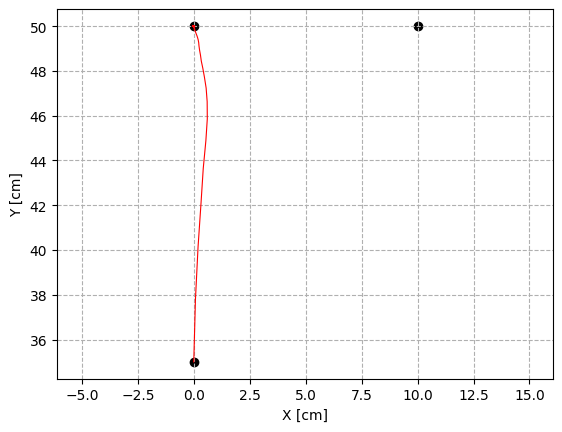

In [3]:
X,Y = Feedback_Linearization(20,3*1e6,3*1e6,1e5,1e5,1e-5,1e-5,JumpTime=20,ShowL = True)

The subject has reached the target after the jump in  0.85  seconds



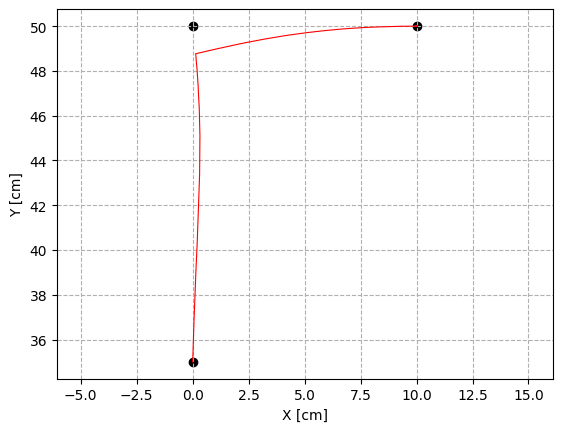

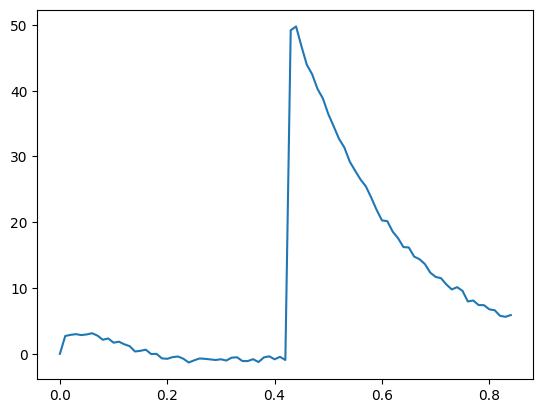

In [7]:
K = 2000
Duration = 20
X,Y = Feedback_Linearization(Duration,3*1e6,3*1e6,1e5,1e5,1e-5,1e-5,JumpTime=.4,Num_iter=K)
plt.show()
dt = Duration/K  # time interval between positions

# Compute velocities (forward difference)
velocities = np.diff(X) / dt

# Compute accelerations (forward difference of velocities)
accelerations = np.diff(X) / dt
time = int(0.85/dt)
plt.plot(np.linspace(0,Duration,K)[:time],accelerations[:time])